In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from docplex.cp.model import  CpoModel
import docplex.cp.utils_visu as visu

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

from utils import extract_solution

Source: Serge Kruk : Practical Python AI Projects, Mathematical Models of Mathematical Models of Google OR-Tools

![alternatvie text](pics/2023-08-02-15-54-00.png)

In [94]:
data = [("J0", (1,10), (2,10), (0,10)),
        ("J1", (1,5), (0,8), (2,5)),
        ("J2", (2,5), (1,9), (0,9)),
        ("J3", (0,6), (2,9), (1,5))]

Jobs = []   

for i in data:
    job = i[0]
    for j in i[1:4]:
        machine = j[0]
        duration = j[1]
        Jobs = Jobs + [[job, machine , duration]]



jobs_data = pd.DataFrame(Jobs, columns = ['job', 'machine' , 'duration'] )


jobs_data['order'] = 'x'
for i in jobs_data['job'].unique():
    jobs_data.loc[jobs_data['job']==i, 'order'] = range(1,4)
jobs_data

,job,machine,duration,order
0,J0,1,10,1
1,J0,2,10,2
2,J0,0,10,3
3,J1,1,5,1
4,J1,0,8,2
5,J1,2,5,3
6,J2,2,5,1
7,J2,1,9,2
8,J2,0,9,3
9,J3,0,6,1


In [95]:
horizon = jobs_data['duration'].sum()
#horizon=40

In [96]:
mdl = CpoModel(name="JobScheduling")

DV=[]
for row in jobs_data.itertuples():

    dv = mdl.interval_var(size  =  row.duration, end = [0, horizon], name='%s_Machine%s'%(row.job, row.machine  ))# ,  , 
    DV.append(dv) 
jobs_data['DV'] = DV
jobs_data

,job,machine,duration,order,DV
0,J0,1,10,1,"J0_Machine1 = intervalVar(end=0..91, size=10)"
1,J0,2,10,2,"J0_Machine2 = intervalVar(end=0..91, size=10)"
2,J0,0,10,3,"J0_Machine0 = intervalVar(end=0..91, size=10)"
3,J1,1,5,1,"J1_Machine1 = intervalVar(end=0..91, size=5)"
4,J1,0,8,2,"J1_Machine0 = intervalVar(end=0..91, size=8)"
5,J1,2,5,3,"J1_Machine2 = intervalVar(end=0..91, size=5)"
6,J2,2,5,1,"J2_Machine2 = intervalVar(end=0..91, size=5)"
7,J2,1,9,2,"J2_Machine1 = intervalVar(end=0..91, size=9)"
8,J2,0,9,3,"J2_Machine0 = intervalVar(end=0..91, size=9)"
9,J3,0,6,1,"J3_Machine0 = intervalVar(end=0..91, size=6)"


In [97]:
precedence_list = []
for job in jobs_data['job'].unique():
    u= jobs_data[jobs_data['job']==job]
    order_list = u['order'].values
    precedence = [[a,b] for a in order_list for b in order_list if a<b]


    for i in precedence:
        first_Task = u[u['order']==i[0]]['DV'].values[0]
        second_Task = u[u['order']==i[1]]['DV'].values[0]
        print("The task ", first_Task , '   should be before   ', second_Task)

        mdl.add( mdl.end_before_start(first_Task  , second_Task ))

The task  J0_Machine1 = intervalVar(end=0..91, size=10)    should be before    J0_Machine2 = intervalVar(end=0..91, size=10)
The task  J0_Machine1 = intervalVar(end=0..91, size=10)    should be before    J0_Machine0 = intervalVar(end=0..91, size=10)
The task  J0_Machine2 = intervalVar(end=0..91, size=10)    should be before    J0_Machine0 = intervalVar(end=0..91, size=10)
The task  J1_Machine1 = intervalVar(end=0..91, size=5)    should be before    J1_Machine0 = intervalVar(end=0..91, size=8)
The task  J1_Machine1 = intervalVar(end=0..91, size=5)    should be before    J1_Machine2 = intervalVar(end=0..91, size=5)
The task  J1_Machine0 = intervalVar(end=0..91, size=8)    should be before    J1_Machine2 = intervalVar(end=0..91, size=5)
The task  J2_Machine2 = intervalVar(end=0..91, size=5)    should be before    J2_Machine1 = intervalVar(end=0..91, size=9)
The task  J2_Machine2 = intervalVar(end=0..91, size=5)    should be before    J2_Machine0 = intervalVar(end=0..91, size=9)
The task  

In [98]:
jobs_data.loc[:,'endtime']=jobs_data['DV'].apply(lambda x:mdl.end_of(x))
jobs_data

,job,machine,duration,order,DV,endtime
0,J0,1,10,1,"J0_Machine1 = intervalVar(end=0..91, size=10)",endOf(J0_Machine1)
1,J0,2,10,2,"J0_Machine2 = intervalVar(end=0..91, size=10)",endOf(J0_Machine2)
2,J0,0,10,3,"J0_Machine0 = intervalVar(end=0..91, size=10)",endOf(J0_Machine0)
3,J1,1,5,1,"J1_Machine1 = intervalVar(end=0..91, size=5)",endOf(J1_Machine1)
4,J1,0,8,2,"J1_Machine0 = intervalVar(end=0..91, size=8)",endOf(J1_Machine0)
5,J1,2,5,3,"J1_Machine2 = intervalVar(end=0..91, size=5)",endOf(J1_Machine2)
6,J2,2,5,1,"J2_Machine2 = intervalVar(end=0..91, size=5)",endOf(J2_Machine2)
7,J2,1,9,2,"J2_Machine1 = intervalVar(end=0..91, size=9)",endOf(J2_Machine1)
8,J2,0,9,3,"J2_Machine0 = intervalVar(end=0..91, size=9)",endOf(J2_Machine0)
9,J3,0,6,1,"J3_Machine0 = intervalVar(end=0..91, size=6)",endOf(J3_Machine0)


In [99]:
all_machines = jobs_data['machine'].unique()

for i in all_machines:
    u= jobs_data[jobs_data['machine']==i]
    
    print(  [k.name for k in  u['DV'].values.tolist()], "  shouldn't overlap")
    mdl.add ( mdl.no_overlap(  u['DV'].values.tolist()))


['J0_Machine1', 'J1_Machine1', 'J2_Machine1', 'J3_Machine1']   shouldn't overlap
['J0_Machine2', 'J1_Machine2', 'J2_Machine2', 'J3_Machine2']   shouldn't overlap
['J0_Machine0', 'J1_Machine0', 'J2_Machine0', 'J3_Machine0']   shouldn't overlap


In [100]:
obj = mdl.minimize ( mdl.max ( jobs_data['endtime']) )

mdl.add(obj)

msol = mdl.solve(TimeLimit=50)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 15 variables, 15 constraints
 ! TimeLimit            = 50
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 43.0 (before), 43.0 (after)
 !  . Memory usage      : 441.7 kB (before), 441.7 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         15                 -
 + New bound is 30
 ! Using iterative diving.
 *            43       25  0.04s        1      (gap is 30.23%)
 *            42       49  0.04s        1      (gap is 28.57%)
              42       80         12    1   F         !presenceOf(J1_Machine1)
 + New bound is 42 (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 2 solutions found.
 ! B

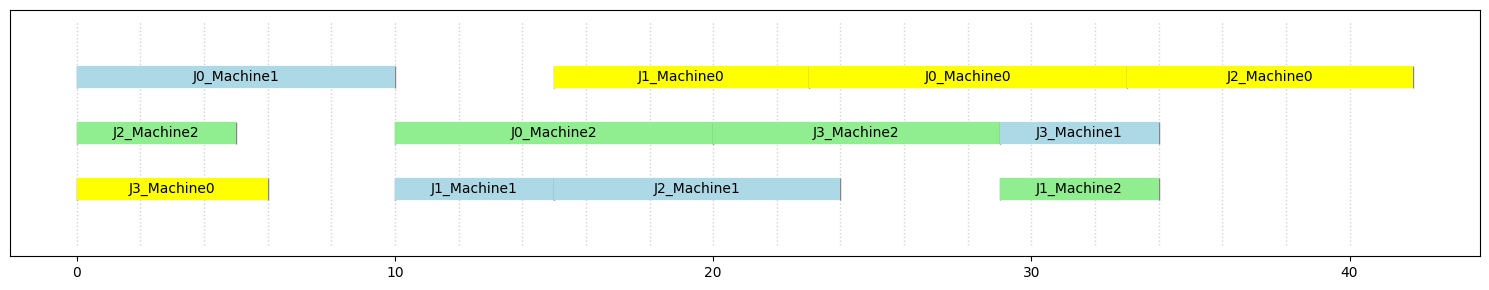

In [101]:
colors = ['yellow', 'lightblue', 'lightgreen', 'red']

for i in DV:
    var_sol = msol.get_var_solution(i)
    machine_id = int(i.name.split('_')[1].replace("Machine",''))
    #visu.panel()
    visu.interval(var_sol, colors[machine_id], i.name, )  
visu.show()

In [102]:
jobs_data['DV_sol'] = jobs_data['DV'].apply(lambda x:msol.get_var_solution(x))
jobs_data['DV_sol_start']=jobs_data['DV_sol'].apply(lambda x:x.get_start())
jobs_data['DV_sol_end']=jobs_data['DV_sol'].apply(lambda x:x.get_end())
jobs_data.sort_values(['DV_sol_start','DV_sol_end'])

,job,machine,duration,order,DV,endtime,DV_sol,DV_sol_start,DV_sol_end
6,J2,2,5,1,"J2_Machine2 = intervalVar(end=0..91, size=5)",endOf(J2_Machine2),"J2_Machine2: (start=0, end=5, size=5, length=5)",0,5
9,J3,0,6,1,"J3_Machine0 = intervalVar(end=0..91, size=6)",endOf(J3_Machine0),"J3_Machine0: (start=0, end=6, size=6, length=6)",0,6
0,J0,1,10,1,"J0_Machine1 = intervalVar(end=0..91, size=10)",endOf(J0_Machine1),"J0_Machine1: (start=0, end=10, size=10, length=10)",0,10
3,J1,1,5,1,"J1_Machine1 = intervalVar(end=0..91, size=5)",endOf(J1_Machine1),"J1_Machine1: (start=10, end=15, size=5, length=5)",10,15
1,J0,2,10,2,"J0_Machine2 = intervalVar(end=0..91, size=10)",endOf(J0_Machine2),"J0_Machine2: (start=10, end=20, size=10, length=10)",10,20
4,J1,0,8,2,"J1_Machine0 = intervalVar(end=0..91, size=8)",endOf(J1_Machine0),"J1_Machine0: (start=15, end=23, size=8, length=8)",15,23
7,J2,1,9,2,"J2_Machine1 = intervalVar(end=0..91, size=9)",endOf(J2_Machine1),"J2_Machine1: (start=15, end=24, size=9, length=9)",15,24
10,J3,2,9,2,"J3_Machine2 = intervalVar(end=0..91, size=9)",endOf(J3_Machine2),"J3_Machine2: (start=20, end=29, size=9, length=9)",20,29
2,J0,0,10,3,"J0_Machine0 = intervalVar(end=0..91, size=10)",endOf(J0_Machine0),"J0_Machine0: (start=23, end=33, size=10, length=10)",23,33
5,J1,2,5,3,"J1_Machine2 = intervalVar(end=0..91, size=5)",endOf(J1_Machine2),"J1_Machine2: (start=29, end=34, size=5, length=5)",29,34
